In [61]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import asyncio
import random
import time

In [8]:
# Graph representing the true network topology, with weights representing bandwidth and current usage.
# Assume the path delay is all the same

G = nx.Graph()
routers = {}
router_ids = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']
ref_bandwidth = 3

# Add nodes (routers) to the graph
G.add_nodes_from(router_ids)

# Add edges (links between routers) with weights (costs)
G.add_edge('A', 'B', band=4, usage = 0)
G.add_edge('A', 'C', band=3, usage = 0)
G.add_edge('B', 'C', band=3, usage = 0)
G.add_edge('B', 'D', band=5, usage = 0)
G.add_edge('C', 'D', band=4, usage = 0)
G.add_edge('C', 'E', band=2, usage = 0)
G.add_edge('D', 'E', band=3, usage = 0)
G.add_edge('E', 'F', band=2, usage = 0)
G.add_edge('D', 'F', band=3, usage = 0)
G.add_edge('I', 'L', band=3, usage = 0)
G.add_edge('E', 'G', band=2, usage = 0)
G.add_edge('D', 'G', band=3, usage = 0)
G.add_edge('G', 'H', band=2, usage = 0)
G.add_edge('G', 'I', band=3, usage = 0)
G.add_edge('F', 'J', band=3, usage = 0)
G.add_edge('J', 'K', band=3, usage = 0)
G.add_edge('J', 'C', band=3, usage = 0)
G.add_edge('K', 'L', band=3, usage = 0)
G.add_edge('A', 'L', band=3, usage = 0)

def reset_usage():
    for u, v, data in G.edges(data=True):
        data['usage'] = 0

# Plot the graph topology and relevant information
def plot_topo():
    np.random.seed(20)
    
    pos = nx.spring_layout(G)  # Define node positions using a spring layout
    nx.draw(G, pos, with_labels=True, node_size=700, node_color="pink")  # Draw nodes
    labels = nx.get_edge_attributes(G, 'band')  # Get edge weights as labels
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)  # Draw edge labels
    plt.title("Network Topology Bandwidth")
    plt.show()

    nx.draw(G, pos, with_labels=True, node_size=700, node_color="lightblue")  # Draw nodes
    labels = nx.get_edge_attributes(G, 'usage')  # Get edge weights as labels
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)  # Draw edge labels
    plt.title("Network Topology Usage")
    plt.show()

    total_band = sum(data['band'] for u, v, data in G.edges(data=True))
    total_usage = sum(data['usage'] for u, v, data in G.edges(data=True))

    print(f"Total band: {total_band}, Total usage: {total_usage}, Link utilization: {round(total_usage/total_band,3)}")
    
    #Router info
    sleeping = 0
    packets_sending = 0
    packets_lost = 0
    for id in routers:
        if routers[id].sleep:
            sleeping += 1
        packets_sending += len(routers[id].packet_dest)
        packets_lost += routers[id].packet_loss
    print(f"Total routers: {len(routers)}, Sleeping: {sleeping}")
    print(f"Packets sent: {packets_sending}, Packets lost: {packets_lost}")

In [77]:
class Router:
    def __init__(self, router_id: str, n_interfaces: int) -> None:
        self.router_id = router_id
        self.links = [None] * n_interfaces

    def _add_link(self, router, interface_no, link):
        if interface_no > len(self.links):
            raise ValueError(f"Specified interface number {interface_no} does not exist on router {self}")
        self.links[interface_no] = link
    
    def remove_link(self, interface_no):
        if interface_no > len(self.links):
            raise ValueError(f"Specified interface number {interface_no} does not exist on router {self}")
        link = self.links[interface_no]
        self.links[interface_no] = None
        return link
    
    def send(self, packet, interface_id):
        if interface_id > len(self.links):
            raise ValueError(f"Specified interface number {interface_id} does not exist on router {self}")
        link = self.links[interface_id]
        if link == None:
            raise ValueError(f"Attempting to send a packet on {interface_id} which is not connected on {self}")
        asyncio.ensure_future(link.send(self, packet))

    def receive(self, packet, interface_no):
        pass
        # print(packet.content)
    
    def broadcast_message(self, packet, exclude_interfaces = []):
        for interface_no in range(len(self.links)):
            # print(f"sending to {interface_no}")
            if interface_no in exclude_interfaces: continue
            if self.links[interface_no] == None: continue
            
            self.send(packet, interface_no)

    def __str__(self) -> str:
        return self.router_id


In [116]:
class Link:
    def __init__(self, bandwidth, delay = 0, loss_rate = 0) -> None:
        self.loss_rate = loss_rate
        self.bandwidth = bandwidth
        self.delay = delay
        self.terminal1 = None
        self.interface1 = None
        self.terminal2 = None
        self.interface2 = None
        self.monitoring = False
        self.last_checkpoint = time.time()
        self.activity_since_checkpoint = 0
        self.activity_rate = 0
    
    def create_link(self, router1, interface1, router2, interface2):
        if self.terminal1 != None or self.terminal2 != None:
            raise RuntimeError(f"Link already has terminals. Please create a new link")
        self.terminal1 = router1
        self.terminal1._add_link(router2, interface1, self)
        self.interface1 = interface1
        self.terminal2 = router2
        self.terminal2._add_link(router1, interface2, self)
        self.interface2 = interface2
    
    def monitor_usage(self):
        self.monitoring = True
    
    def stop_monitoring(self):
        self.monitoring = False

    def get_activity_rate(self):
        current_activity_rate = self.activity_rate
        if time.time() - self.last_checkpoint > 1:
            self.last_checkpoint = time.time()
            self.activity_rate = 0
            self.activity_since_checkpoint = 0
        return current_activity_rate
    
    def opposite_terminal(self, terminal):
        """Return what router is on the opposite end of this link

        Args:
            terminal (Router): current end

        Raises:
            ValueError: if this is called with a router that is not connected to this link

        Returns:
            Router: router on the other end
        """
        if terminal not in (self.terminal1, self.terminal2):
            raise ValueError(f"Link {self.terminal1} - {self.terminal2} queried with a router which is not one of its terminals")
       
        return self.terminal1 if terminal == self.terminal2 else self.terminal2

    async def send(self, sending_router, packet):
        if sending_router not in (self.terminal1, self.terminal2):
            raise ValueError(f"Link {self.terminal1} - {self.terminal2} asked to send with a router which is not on either of its ends")
        
        receiving_router = self.terminal1 if sending_router == self.terminal2 else self.terminal2
        receiving_interface = self.interface1 if sending_router == self.terminal2 else self.interface2
        
        # print(f"{sending_router} sending message to {receiving_router}...")

        if self.monitoring:
            self.activity_since_checkpoint += packet.length
            if time.time() - self.last_checkpoint > 1:
                self.activity_rate = self.activity_since_checkpoint / self.bandwidth
                self.activity_since_checkpoint = 0
                self.last_checkpoint = time.time()

        # Simulate delay
        if self.delay != 0:
            await asyncio.sleep(self.delay)

        # Randomly drop packets
        if random.random() < self.loss_rate:
            print(f"Packet lost from link {self.terminal1} - {self.terminal2}!")
            return

        receiving_router.receive(packet, receiving_interface)


In [127]:
class Packet:
    def __init__(self, length, content) -> None:
        self.length = length    # dummy length
        self.content = content
        self.header = {}
    
class LSA(Packet):
    LSDB = 0    # link state database
    LSCUP = 1   # link state cut update (cut an unnecessary link)
    LSGUP = 2   # link state graft update (reactivate a link)
    
    def __init__(self, length, lsa_type, origin_router_id, content) -> None:
        super().__init__(length, content)
        self.header["router_id"] = origin_router_id
        self.header["lsa_type"] = lsa_type

class T1LSA(LSA):
    def __init__(self, type, origin_router_id, link_entries, lsa_id) -> None:
        super().__init__(0, type, origin_router_id, link_entries)
        self.header["id"] = lsa_id

class LinkEntry:
    def __init__(self, router_id, link_id, cost):
        self.router_id = router_id
        self.link_id = link_id
        self.cost = cost

class LinkStateDatabase:
    def __init__(self, router_id) -> None:
        self.lsa_db = {}    # this will be indexed by router id for easy retrieval. Contains collected LSAs
        self.router_id = router_id
        self.graph = nx.Graph() # actual topology graph
        self.graph.add_node(router_id)
    
    def update_db(self, lsa_message: T1LSA):
        router_id =  lsa_message.header["router_id"]
        lsa_id = lsa_message.header["id"]
        if router_id in self.lsa_db and self.lsa_db[router_id].header["id"] >= lsa_id:
            # if a more recent LSA exists inside the database already, ignore this one.
            return False
        
        self.lsa_db[router_id] = lsa_message

        # now, update the graph
        if router_id in self.graph:
            # remove all edges except the one that I share with the router
            neighbour = False
            if (self.router_id, router_id) in self.graph.edges:
                neighbour = True
                data = self.graph.get_edge_data(self.router_id, router_id)
            self.graph.remove_node(router_id)
            if neighbour:
                self.graph.add_edge(self.router_id, router_id, **data)

        for link_entry in lsa_message.content:
            # if the link is with myself, skip adding it to the database
            if link_entry.router_id == self.router_id:
                continue

            self.graph.add_node(link_entry.router_id)
            self.graph.add_edge(router_id, link_entry.router_id, cost=link_entry.cost)
        
        # This was a new message, so broadcast it
        return True
    
    def find_shortest_path(self, target_router):
        return nx.shortest_path(self.graph, self.router_id, target_router)


In [136]:
class OSPFRouter(Router):
    # OSPF neighbour states. Only using DOWN and FULL for now
    DOWN = 0
    INIT = 1
    EXSTART = 2
    EXCHANGE = 3
    LOADING = 4
    FULL = 5
    
    def __init__(self, router_id: str, n_interfaces: int) -> None:
        super().__init__(router_id, n_interfaces)
        self.sleeping = False
        self.link_state_db = LinkStateDatabase(router_id)
        self.neighbour_states = [self.DOWN] * n_interfaces
        self.neighbours_link_entries = [None] * n_interfaces
        self.lsa_id_counter = 0
    
    def _add_link(self, router, interface_no, link):
        super()._add_link(router, interface_no, link)
        self.link_state_db.graph.add_node(router.router_id)
        self.link_state_db.graph.add_edge(self.router_id, router.router_id, cost = self.link_cost(link.bandwidth))
        self.neighbour_states[interface_no] = self.FULL # don't do the other states for now
        self.neighbours_link_entries[interface_no] = LinkEntry(router.router_id, self.router_id + router.router_id, self.link_cost(link.bandwidth))

    def remove_link(self, interface_no):
        link = super().remove_link(self, interface_no)
        self.neighbour_states[interface_no] = self.DOWN
        connected_router = link.opposite_terminal(self)
        self.link_state_db.remove_edge(self, connected_router)
    
    def send_message(self, target_router, packet):
        packet.header["target_router"] = target_router
        self.route_message(packet)
    
    def route_message(self, packet):
        target_router = packet.header["target_router"]
        next_hop = self.link_state_db.find_shortest_path(target_router)[1]
        for intfc, link_entry in enumerate(self.neighbours_link_entries):
            if link_entry.router_id == next_hop:
                next_hop_interface = intfc
                print(f"sending to {next_hop_interface}")
                self.send(packet, next_hop_interface)
                break

    def receive(self, packet, interface_no):
        super().receive(packet, interface_no)
        if isinstance(packet, LSA):
            new_lsa = self.update_lsdb(packet)
            if new_lsa:
                # print(f"sending to others")
                self.broadcast_message(packet, [interface_no])
        else:
            if packet.header["target_router"] == self.router_id:
                print(packet.content)
            else:
                self.route_message(packet)

    def update_lsdb(self, lsa_message):
        return self.link_state_db.update_db(lsa_message)

    def broadcast_LSA(self):
        entries = []
        for le in self.neighbours_link_entries:
            if le == None: continue
            entries.append(le)
        lsa = T1LSA(type=LSA.LSDB, origin_router_id=self.router_id, link_entries=entries, lsa_id=self.lsa_id_counter)
        self.lsa_id_counter += 1
        self.broadcast_message(lsa)
        
    @staticmethod
    def link_cost(bandwidth):
        # cost is inversely proportional to bandwidth
        return 1 / bandwidth
            

In [137]:
l1 = LinkEntry("b", 12, 34)
l2 = LinkEntry("c", 13, 20)
l3 = LinkEntry("d", 14, 24)
l4 = LinkEntry("e", 15, 20)
links = [l1, l2, l3, l4]
# m1 = T1LSA(100, LSA.LSDB, "a", links, 10)
# print(m1.header.keys())
a = OSPFRouter("a", n_interfaces=5)
b = OSPFRouter("b", n_interfaces=1)
c = OSPFRouter("c", n_interfaces=1)
d = OSPFRouter("d", n_interfaces=1)
e = OSPFRouter("e", n_interfaces=2)
ab = Link(10)
ac = Link(5)
ad = Link(15)
ae = Link(0.05)
ab.create_link(a, 0, b, 0)
ac.create_link(a, 1, c, 0)
ad.create_link(a, 2, d, 0)
ae.create_link(a, 3, e, 0)
# e.update_lsdb(m1)
print(e.link_state_db.graph.edges(data=True))
test_pkt = Packet(100, "test packet")
ab.monitor_usage()
a.broadcast_LSA()
await asyncio.sleep(1)
b.broadcast_LSA()
await asyncio.sleep(1)
c.broadcast_LSA()
await asyncio.sleep(1)
d.broadcast_LSA()
await asyncio.sleep(1)
e.broadcast_LSA()
await asyncio.sleep(1)
c.send_message("b", test_pkt)

# l3 = LinkEntry("d", 14, 57)
# links = [l1, l2, l3, l4]
# m2 = T1LSA(100, LSA.LSDB, "a", links, 10)
# e.update_lsdb(m2)
# print(e.link_state_db.graph.edges(data=True))
# l3 = LinkEntry("d", 14, 109)
# links = [l1, l2, l3, l4]
# m3 = T1LSA(100, LSA.LSDB, "a", links, 10)
# e.update_lsdb(m3)
await asyncio.sleep(1)
print(a.link_state_db.graph.edges(data=True))
print(b.link_state_db.graph.edges(data=True))
print(c.link_state_db.graph.edges(data=True))
print(ab.activity_rate)

[('e', 'a', {'cost': 20.0})]
sending to 0
sending to 0
test packet
[('a', 'b', {'cost': 0.1}), ('a', 'c', {'cost': 0.2}), ('a', 'd', {'cost': 0.06666666666666667}), ('a', 'e', {'cost': 20.0})]
[('b', 'a', {'cost': 0.1}), ('a', 'c', {'cost': 0.2}), ('a', 'd', {'cost': 0.06666666666666667}), ('a', 'e', {'cost': 20.0})]
[('c', 'a', {'cost': 0.2}), ('a', 'b', {'cost': 0.1}), ('a', 'd', {'cost': 0.06666666666666667}), ('a', 'e', {'cost': 20.0})]
10.0


In [75]:
class Router:
    def __init__(self, id, G):
        self.id = id # String identifier
        self.link_state_db = G # For simplicity, assume each router start with a converged topo
        self.sleep = False # Eco-router sleep status for GOSPF

        self.packet_dest= {} # Destinations being sent packets originated from this router
        self.packet_loss= 0

    def calc_cost(self):
        # Define link cost as ref_bandwidth / (bandwidth - usage)
        for u, v, data in G.edges(data=True):
            if data['band'] - data['usage'] == 0:
                data['cost'] = float('inf')
            else:
                data['cost'] = ref_bandwidth / (data['band'] - data['usage'])
         
    def plot_ls_db(self):
        self.calc_cost()
        # Plot the graph with cost
        np.random.seed(20)
        
        pos = nx.spring_layout(self.link_state_db)  # Define node positions using a spring layout
        nx.draw(self.link_state_db, pos, with_labels=True, node_size=700, node_color="lightblue")  # Draw nodes
        labels = nx.get_edge_attributes(self.link_state_db, 'cost')  # Get edge weights as labels
        nx.draw_networkx_edge_labels(self.link_state_db, pos, edge_labels=labels)  # Draw edge labels
        plt.title(f"Link State Database of Router {self.id} with Costs")
        plt.show()

    def randomize_packet_dest(self, pkt_count):
        self.packet_dest = {}
        for pkt in range(pkt_count):
            random_id = random.choice([item for item in router_ids if item != self.id])
            if random_id in self.packet_dest:
                self.packet_dest[random_id] += 1
            else:
                self.packet_dest[random_id] = 1

    def send_packets(self):
        # Compute shortest path using Djikstra algorithm
        def get_path(target_id):
            return nx.shortest_path(self.link_state_db, source=self.id, target=target_id, weight='cost')
        
        self.calc_cost()
        self.packet_loss = 0
        for dest in self.packet_dest:
            path = get_path(dest)
            path_avail = True
            for u, v in zip(path[:-1], path[1:]):
                if G[u][v]['usage'] >= G[u][v]['band']:
                    print(f"Max usage: {dest} unreachable from {self.id}")
                    self.packet_loss += 1
                    path_avail = False
                    break
            
            if path_avail:
                for u, v in zip(path[:-1], path[1:]):
                    G[u][v]['usage'] += 1
                print(f"Sending packet: {self.id} to {dest}")

Sending packet: E to L
Sending packet: E to B
Sending packet: H to G
Sending packet: J to F
Sending packet: J to H


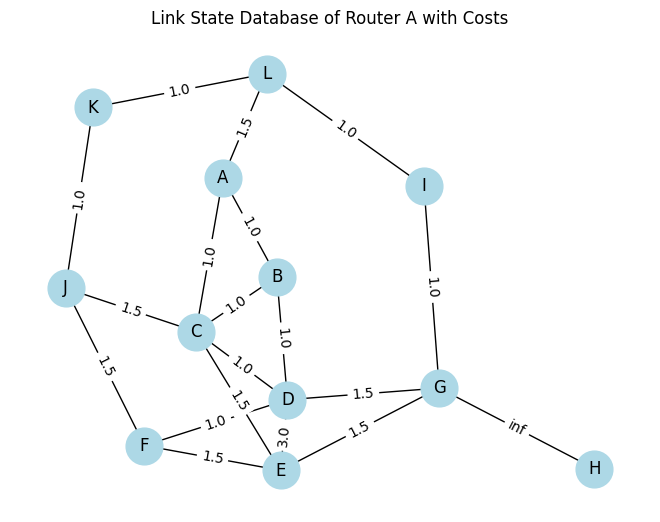

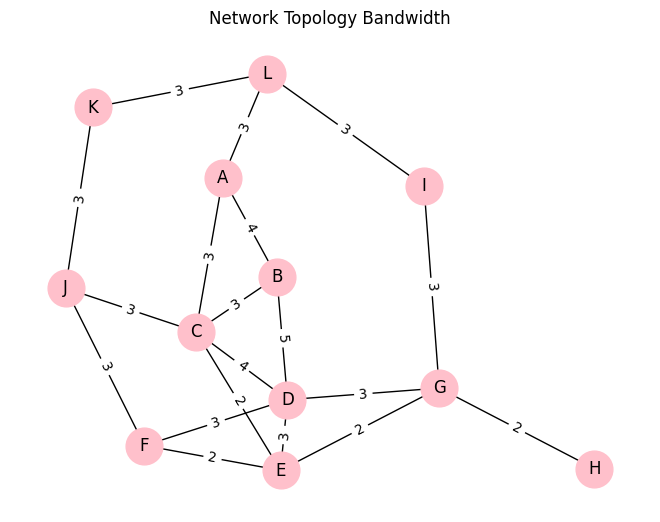

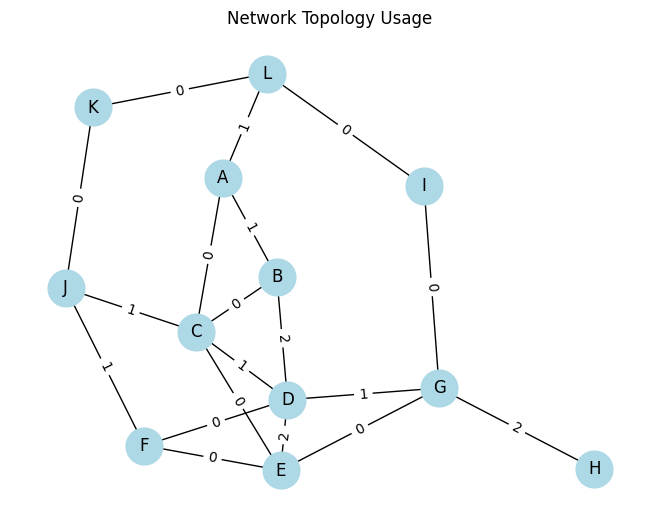

Total band: 57, Total usage: 12, Link utilization: 0.211
Total routers: 12, Sleeping: 0
Packets sent: 5, Packets lost: 0


In [76]:
# Basic OSPF

random.seed(20)
reset_usage()

for id in router_ids:
    routers[id] = Router(id, G)
    if random.random() < 0.3:
        routers[id].randomize_packet_dest(2)
        routers[id].send_packets()

routers['A'].plot_ls_db()
plot_topo()

In [ ]:
#GOSPF
